In [1]:
import os
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import math

In [2]:
mc_value = 1000000
nVelocity = 401
minx = -100
maxx = 100
velocityArray = np.linspace(minx,maxx,nVelocity)

# Planet located at (0, 1.05xR_J)
x_p_list = np.array([0])
y_p_list = np.array([0.50365])
training_profiles_to_generate = int(len(x_p_list))

In [3]:
observer_angle = 0
vel_eq = 25

In [4]:
# definition of the gaussian profile
def gaussian_fct(x, amp, cen, sigma):
    return amp*(np.exp((-1.0/2.0)*(((x-cen)/sigma)**2)))

# velocity shift
def shift_profile_velocity(x, y, velocity):
    shift = velocity
    xshifted = x + shift
    yshifted = np.interp(x, xshifted, y)
    return yshifted

# limb darkening
def limb_dark(eps,radius):
    ld = 1.0 - eps + eps*np.cos(np.arcsin(radius))
    return ld

# projected rotational velocity
def proj_vel(vel_eq, x_comp, observer_angle):
    pv = vel_eq * x_comp * np.cos(np.radians(observer_angle))
    return pv

# mc integration
def mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, n_mc):
    r_s, r_p = 1.0, 0.156
    x_p, y_p = x_p, y_p
    vel_eq, eps = vel_eq, 0.7
    n_mc = n_mc
    r_act = r_s

    amplitude = 0.9
    center = 0.0
    sigma = 5.0

    n_out = 0
    checkflux1 = 0.0
    checkflux2 = 0.0

    velocityArray = np.linspace(minx,maxx,nVelocity)
    flux_profile = np.zeros([nVelocity])
    flux = 0.0
    int_profile = gaussian_fct(velocityArray, amplitude, center, sigma)

    x_array_mc = np.zeros([n_mc])
    y_array_mc = np.zeros([n_mc])
    r_array_mc = np.zeros([n_mc])

    # Vectorized version
    np.random.seed(24)
    theta_mc = np.random.uniform(0, 2.*np.pi, n_mc)
    r_mc = np.random.uniform(0, r_act, n_mc)

    for i in range(n_mc):

        x_mc = np.sqrt(r_mc[i]) * np.cos(theta_mc[i])
        y_mc = np.sqrt(r_mc[i]) * np.sin(theta_mc[i])
        check_planet = (np.abs(x_mc-x_p))**2 + (np.abs(y_mc-y_p)**2) > r_p**2

        if check_planet:
            x_array_mc[i] = x_mc
            y_array_mc[i] = y_mc
            r_array_mc[i] = np.sqrt(x_mc**2 + y_mc**2)
            pv = proj_vel(vel_eq,x_mc,observer_angle)
            ld = limb_dark(eps,r_array_mc[i])
            local_profile = shift_profile_velocity(velocityArray, int_profile, pv)
            local_profile = local_profile * ld
            flux_profile = flux_profile + local_profile
            flux = flux + ld
            n_out = n_out + 1

    flux = flux*(r_s**2)/(r_act**2)
    flux_profile = flux_profile/flux
    flux_profile = flux_profile.reshape(-1, nVelocity)

    return flux_profile, flux

Time to generate 1 training profiles: 0.01 hours


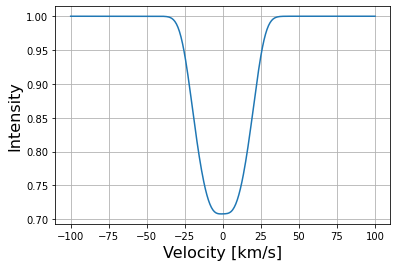

In [5]:
simulate_start_time = time.time()
coordinates_list = []
intensities_list = []
for i in range(training_profiles_to_generate):
    x_p = x_p_list[i]
    y_p = y_p_list[i]
    try:
        flux_profile, flux = mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, mc_value)
        flux_profile = 1.0 - flux_profile
        # Append new data to the lists
        coordinates_list.append([x_p, y_p])
        intensities_list.append(flux_profile)
    except Exception as e:
        print(f"Error while processing profile {i}: {str(e)}")
# Convert the lists to numpy arrays
coordinates_array = np.array(coordinates_list)
intensities_array = np.squeeze(np.array(intensities_list), axis=1)
simulate_end_time = time.time()
simulate_time = simulate_end_time - simulate_start_time
print(f"Time to generate {training_profiles_to_generate} training profiles: {round((simulate_time)/3600, 2)} hours")

flux_profiles_1 = np.squeeze(intensities_list)

if training_profiles_to_generate == 1:
    plt.plot(velocityArray, flux_profiles_1)
else:
    for flux_profile in flux_profiles_1:
        plt.plot(velocityArray, flux_profile)
plt.xlabel('Velocity [km/s]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.grid()
plt.show()

In [6]:
# mc integration
def mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, n_mc):
    r_s, r_p = 1.0, 0.156+(0.156 * 0.05)
    x_p, y_p = x_p, y_p
    vel_eq, eps = vel_eq, 0.7
    n_mc = n_mc
    r_act = r_s

    amplitude = 0.9
    center = 0.0
    sigma = 5.0

    n_out = 0
    checkflux1 = 0.0
    checkflux2 = 0.0

    velocityArray = np.linspace(minx,maxx,nVelocity)
    flux_profile = np.zeros([nVelocity])
    flux = 0.0
    int_profile = gaussian_fct(velocityArray, amplitude, center, sigma)

    x_array_mc = np.zeros([n_mc])
    y_array_mc = np.zeros([n_mc])
    r_array_mc = np.zeros([n_mc])

    # Vectorized version
    np.random.seed(24)
    theta_mc = np.random.uniform(0, 2.*np.pi, n_mc)
    r_mc = np.random.uniform(0, r_act, n_mc)

    for i in range(n_mc):

        x_mc = np.sqrt(r_mc[i]) * np.cos(theta_mc[i])
        y_mc = np.sqrt(r_mc[i]) * np.sin(theta_mc[i])
        check_planet = (np.abs(x_mc-x_p))**2 + (np.abs(y_mc-y_p)**2) > r_p**2

        if check_planet:
            x_array_mc[i] = x_mc
            y_array_mc[i] = y_mc
            r_array_mc[i] = np.sqrt(x_mc**2 + y_mc**2)
            pv = proj_vel(vel_eq,x_mc,observer_angle)
            ld = limb_dark(eps,r_array_mc[i])
            local_profile = shift_profile_velocity(velocityArray, int_profile, pv)
            local_profile = local_profile * ld
            flux_profile = flux_profile + local_profile
            flux = flux + ld
            n_out = n_out + 1

    flux = flux*(r_s**2)/(r_act**2)
    flux_profile = flux_profile/flux
    flux_profile = flux_profile.reshape(-1, nVelocity)

    return flux_profile, flux

Time to generate 1 training profiles: 0.01 hours


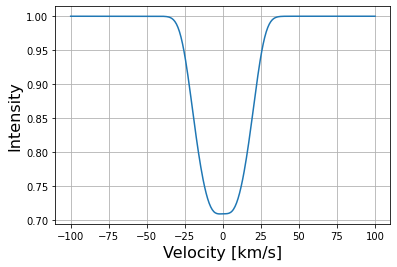

In [7]:
simulate_start_time = time.time()
coordinates_list = []
intensities_list = []
for i in range(training_profiles_to_generate):
    x_p = x_p_list[i]
    y_p = y_p_list[i]
    try:
        flux_profile, flux = mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, mc_value)
        flux_profile = 1.0 - flux_profile
        # Append new data to the lists
        coordinates_list.append([x_p, y_p])
        intensities_list.append(flux_profile)
    except Exception as e:
        print(f"Error while processing profile {i}: {str(e)}")
# Convert the lists to numpy arrays
coordinates_array = np.array(coordinates_list)
intensities_array = np.squeeze(np.array(intensities_list), axis=1)
simulate_end_time = time.time()
simulate_time = simulate_end_time - simulate_start_time
print(f"Time to generate {training_profiles_to_generate} training profiles: {round((simulate_time)/3600, 2)} hours")

flux_profiles_2 = np.squeeze(intensities_list)

if training_profiles_to_generate == 1:
    plt.plot(velocityArray, flux_profiles_2)
else:
    for flux_profile in flux_profiles_2:
        plt.plot(velocityArray, flux_profile)
plt.xlabel('Velocity [km/s]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.grid()
plt.show()

In [8]:
x_p_list = np.array([5])
y_p_list = np.array([5])

Time to generate 1 training profiles: 0.01 hours


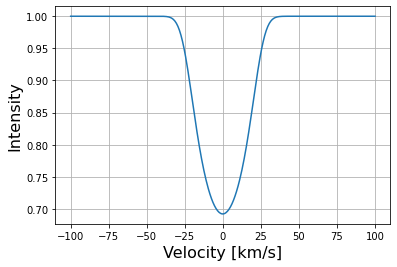

In [9]:
simulate_start_time = time.time()
coordinates_list = []
intensities_list = []
for i in range(training_profiles_to_generate):
    x_p = x_p_list[i]
    y_p = y_p_list[i]
    try:
        flux_profile, flux = mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, mc_value)
        flux_profile = 1.0 - flux_profile
        # Append new data to the lists
        coordinates_list.append([x_p, y_p])
        intensities_list.append(flux_profile)
    except Exception as e:
        print(f"Error while processing profile {i}: {str(e)}")
# Convert the lists to numpy arrays
coordinates_array = np.array(coordinates_list)
intensities_array = np.squeeze(np.array(intensities_list), axis=1)
simulate_end_time = time.time()
simulate_time = simulate_end_time - simulate_start_time
print(f"Time to generate {training_profiles_to_generate} training profiles: {round((simulate_time)/3600, 2)} hours")

oot = np.squeeze(intensities_list)

if training_profiles_to_generate == 1:
    plt.plot(velocityArray, oot)
else:
    for flux_profile in oot:
        plt.plot(velocityArray, flux_profile)
plt.xlabel('Velocity [km/s]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.grid()
plt.show()

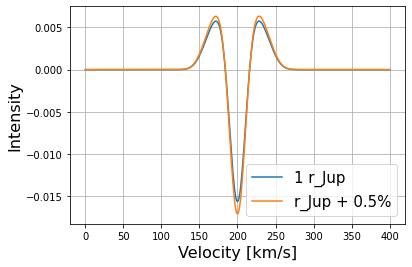

In [10]:
diff_1 = oot - flux_profiles_1
diff_2 = oot - flux_profiles_2

plt.plot(diff_1, label = "1 r_Jup")
plt.plot(diff_2, label = "r_Jup + 0.5%")
plt.xlabel('Velocity [km/s]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.legend(fontsize=15, loc='lower right' )
plt.grid()
plt.show()

In [11]:
range_1 = max(diff_1)-min(diff_1)
range_2 = max(diff_2)-min(diff_2)
avg = (range_1 + range_2) / 2
print(range_2)

0.023392116769486493


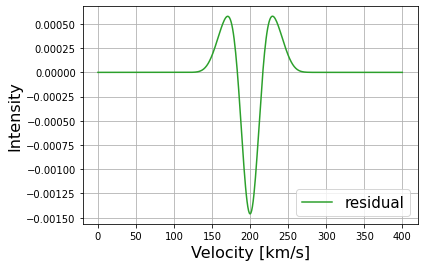

In [12]:
diff_diff = diff_2 - diff_1

plt.plot(diff_diff, label = "residual", color="C2")
plt.xlabel('Velocity [km/s]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.legend(fontsize=15, loc='lower right' )
plt.grid()
plt.show()

In [13]:
range_3 = max(diff_diff)-min(diff_diff)
scale_1 = avg / range_3
print(scale_1)

10.966014901235866


In [14]:
# mc integration
def mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, n_mc):
    r_s, r_p = 1.0, 0.156
    x_p, y_p = x_p, y_p
    vel_eq, eps = vel_eq, 0.7
    n_mc = n_mc
    r_act = r_s

    amplitude = 0.9
    center = 0.0
    sigma = 5.0

    n_out = 0
    checkflux1 = 0.0
    checkflux2 = 0.0

    velocityArray = np.linspace(minx,maxx,nVelocity)
    flux_profile = np.zeros([nVelocity])
    flux = 0.0
    int_profile = gaussian_fct(velocityArray, amplitude, center, sigma)

    x_array_mc = np.zeros([n_mc])
    y_array_mc = np.zeros([n_mc])
    r_array_mc = np.zeros([n_mc])

    # Vectorized version
    np.random.seed(24)
    theta_mc = np.random.uniform(0, 2.*np.pi, n_mc)
    r_mc = np.random.uniform(0, r_act, n_mc)

    for i in range(n_mc):

        x_mc = np.sqrt(r_mc[i]) * np.cos(theta_mc[i])
        y_mc = np.sqrt(r_mc[i]) * np.sin(theta_mc[i])
        check_planet = (np.abs(x_mc-x_p))**2 + (np.abs(y_mc-y_p)**2) > r_p**2

        if check_planet:
            x_array_mc[i] = x_mc
            y_array_mc[i] = y_mc
            r_array_mc[i] = np.sqrt(x_mc**2 + y_mc**2)
            pv = proj_vel(vel_eq,x_mc,observer_angle)
            ld = limb_dark(eps,r_array_mc[i])
            local_profile = shift_profile_velocity(velocityArray, int_profile, pv)
            local_profile = local_profile * ld
            flux_profile = flux_profile + local_profile
            flux = flux + ld
            n_out = n_out + 1

    flux = flux*(r_s**2)/(r_act**2)
    flux_profile = flux_profile/flux
    flux_profile = flux_profile.reshape(-1, nVelocity)

    return flux_profile, flux

In [15]:
x_p_list = np.array([0])
y_p_list = np.array([0])
#y_p_list = np.array([0.156])

Time to generate 1 training profiles: 0.01 hours


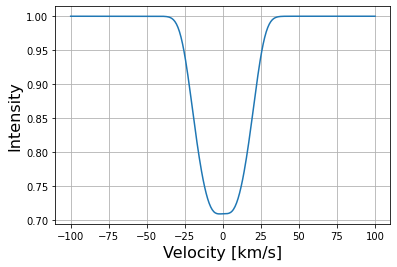

In [16]:
simulate_start_time = time.time()
coordinates_list = []
intensities_list = []
for i in range(training_profiles_to_generate):
    x_p = x_p_list[i]
    y_p = y_p_list[i]
    try:
        flux_profile, flux = mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, mc_value)
        flux_profile = 1.0 - flux_profile
        # Append new data to the lists
        coordinates_list.append([x_p, y_p])
        intensities_list.append(flux_profile)
    except Exception as e:
        print(f"Error while processing profile {i}: {str(e)}")
# Convert the lists to numpy arrays
coordinates_array = np.array(coordinates_list)
intensities_array = np.squeeze(np.array(intensities_list), axis=1)
simulate_end_time = time.time()
simulate_time = simulate_end_time - simulate_start_time
print(f"Time to generate {training_profiles_to_generate} training profiles: {round((simulate_time)/3600, 2)} hours")

flux_profiles_3 = np.squeeze(intensities_list)

if training_profiles_to_generate == 1:
    plt.plot(velocityArray, flux_profiles_3)
else:
    for flux_profile in flux_profiles_3:
        plt.plot(velocityArray, flux_profile)
plt.xlabel('Velocity [km/s]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.grid()
plt.show()

In [17]:
diff_3 = oot - flux_profiles_3

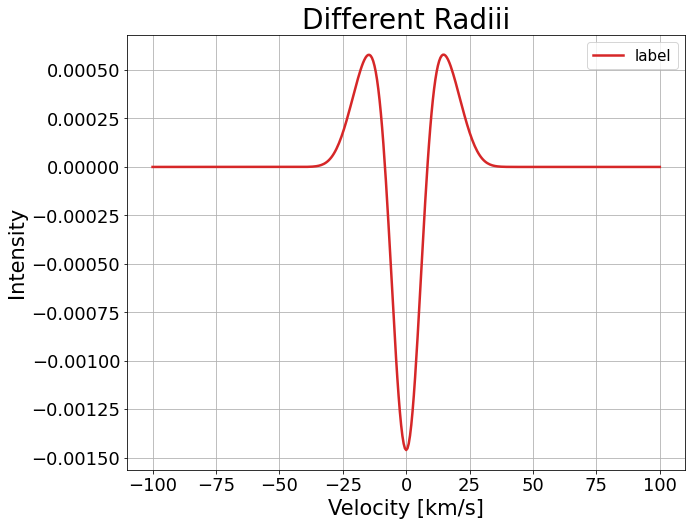

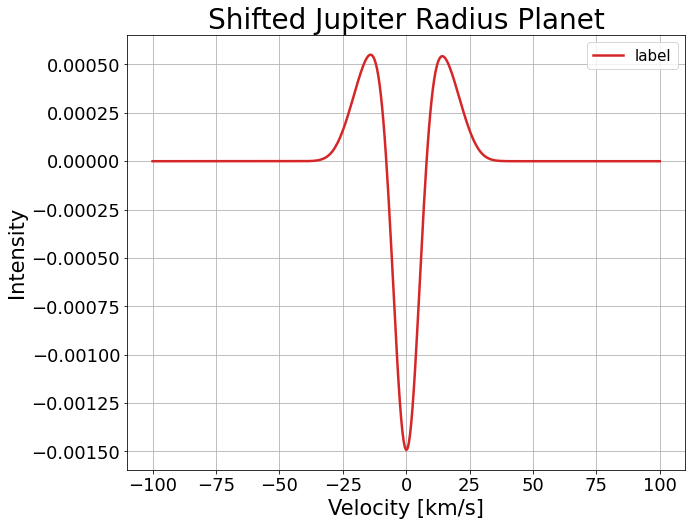

In [18]:
diff_21 = diff_2 - diff_1

plt.figure(figsize=(10, 8))
plt.title("Different Radiii", fontsize=28)
#plt.plot(velocityArray, diff_1, label = "$R_{J}$ (0.5, 0.5)", linewidth=2.5, color="C2")
#plt.plot(velocityArray, diff_2, label = "$1.05 x R_{J}$ (0.5, 0.5)", linewidth=2.5, color="C3")
plt.plot(velocityArray, diff_21, label = "label", linewidth=2.5, color="C3")
plt.xlabel('Velocity [km/s]', fontsize=21)
plt.xticks(fontsize=18)
plt.ylabel('Intensity', fontsize=21)
plt.yticks(fontsize=18)
plt.legend(fontsize=15, loc='upper right' )
plt.grid()
plt.show()

diff_31 = diff_3 - diff_1

plt.figure(figsize=(10, 8))
plt.title("Shifted Jupiter Radius Planet", fontsize=28)
#plt.plot(velocityArray, diff_1, label = "$R_{J}$ (0.5, 0.5)", linewidth=2.5, color="C2")
#plt.plot(velocityArray, diff_3, label = "$R_{J}$ (0.5, 0.3)", linewidth=2.5, color="C3")
plt.plot(velocityArray, diff_31, label = "label", linewidth=2.5, color="C3")
plt.xlabel('Velocity [km/s]', fontsize=21)
plt.xticks(fontsize=18)
plt.ylabel('Intensity', fontsize=21)
plt.yticks(fontsize=18)
plt.legend(fontsize=15, loc='upper right' )
plt.grid()
plt.show()

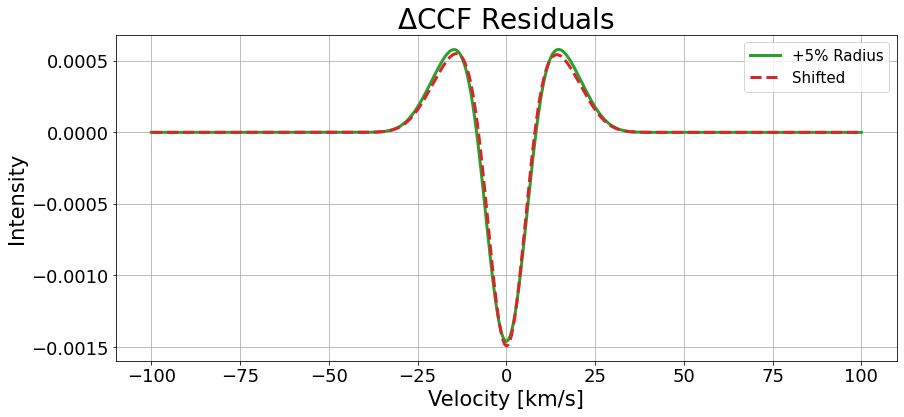

In [24]:
plt.figure(figsize=(14, 6))
plt.title("$\Delta$CCF Residuals", fontsize=28)
#plt.plot(velocityArray, diff_1, label = "$R_{J}$ (0.5, 0.5)", linewidth=2.5, color="C2")
#plt.plot(velocityArray, diff_3, label = "$R_{J}$ (0.5, 0.3)", linewidth=2.5, color="C3")
plt.plot(velocityArray, diff_21, label = "+5% Radius", linewidth=3, color="C2")
plt.plot(velocityArray, diff_31, label = "Shifted", linewidth=3, linestyle="--", color="C3")
plt.xlabel('Velocity [km/s]', fontsize=21)
plt.xticks(fontsize=18)
plt.ylabel('Intensity', fontsize=21)
plt.yticks(fontsize=18)
plt.legend(fontsize=15, loc='upper right' )
plt.grid()
plt.savefig("Delta_CCF_Test.pdf", format="pdf")
plt.show()

In [20]:
range_4 = max(diff_3)-min(diff_3)
print(range_4)

0.02339181254893996
